<a href="https://colab.research.google.com/github/reza74rsa/Cellectors/blob/main/cellular_segmentation_using_U_Net_and_weighted_map_new_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Setup

In [ ]:
# @title Install dependencies
!pip install opencv-python --quiet
!pip install numba --quiet
!pip install tifffile --quiet

!pip install elasticdeform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.9 MB/s 


In [ ]:
# Imports
import os
import cv2
import tqdm
import hashlib
import requests

import elasticdeform

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from numba import jit

from scipy.ndimage import gaussian_filter
from scipy.ndimage import find_objects, binary_fill_holes
from scipy.ndimage import generate_binary_structure, label
from scipy.optimize import linear_sum_assignment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data loading

In [ ]:
# @title Download and normalize data
filenames = ["cells_train.npz",
             "cells_test.npz"]
urls = ["https://osf.io/z3h78/download",
        "https://osf.io/ft5p3/download"]
expected_md5s = ["85e1fe2ee8d936c1083d62563d79d958",
                 "e8f789abe20a7efde806d9ba03d20fd7"]

for fname, url, expected_md5 in zip(filenames, urls, expected_md5s):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      elif hashlib.md5(r.content).hexdigest() != expected_md5:
        print("!!! Data download appears corrupted !!!")
      else:
        with open(fname, "wb") as fid:
          fid.write(r.content)

cells_train = np.load('cells_train.npz', allow_pickle=True)['arr_0'].item()
cells_test = np.load('cells_test.npz', allow_pickle=True)['arr_0'].item()
imgs_train = np.array(cells_train['imgs']).transpose(0, 3, 1, 2)
masks_train = np.array(cells_train['masks'])
imgs_test = np.array(cells_test['imgs']).transpose(0, 3, 1, 2)
masks_test = np.array(cells_test['masks'])

# we are going to normalize the images so their pixel values mostly fall between 0 and 1
# this is helpful if you have images on a variety of scales
# we will also return the images as float32 <- the data type that is fast for GPU computation
def normalize99(img):
  """ normalize image so 0.0 is 1st percentile and 1.0 is 99th percentile """
  X = img.copy()
  x01 = np.percentile(X, 1)
  x99 = np.percentile(X, 99)
  X = (X - x01) / (x99 - x01)
  return X.astype(np.float32)


imgs_train = np.array([normalize99(img) for img in imgs_train])
imgs_test = np.array([normalize99(img) for img in imgs_test])

Plot a random training image and its masks. Note the masks are labels from 1, ... to the number of cells.

there are 72 cells in this image


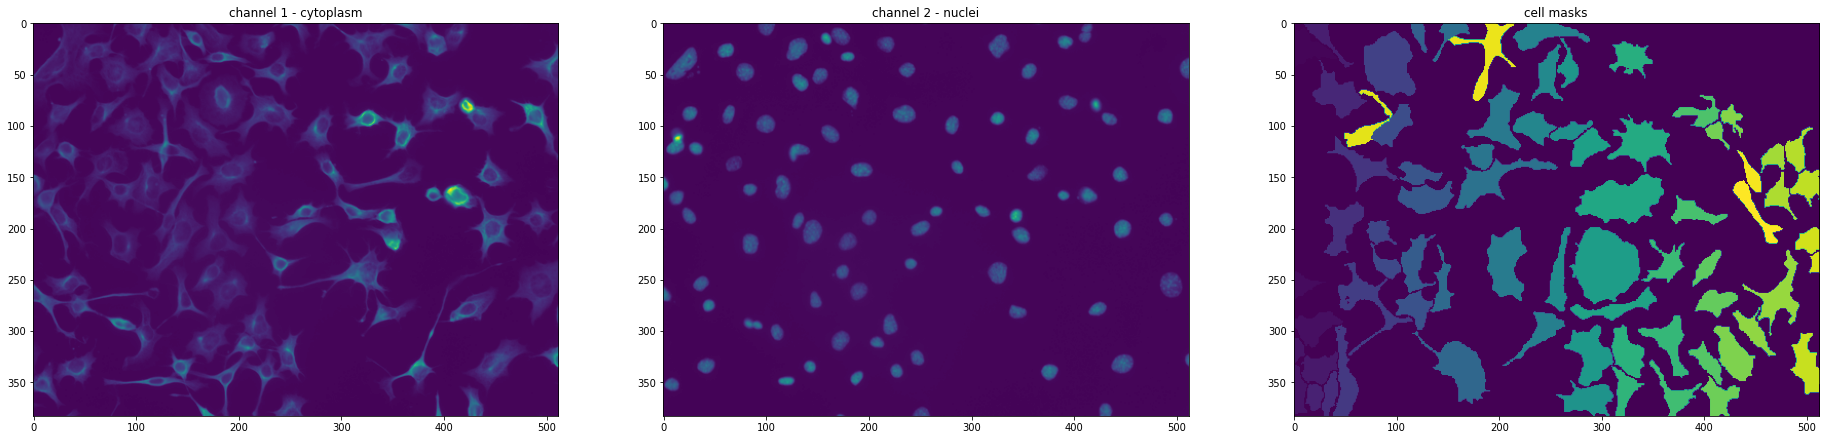

In [ ]:
irand = np.random.randint(len(imgs_train))

plt.figure(figsize=(32, 16))
plt.subplot(1, 3, 1)
plt.imshow(imgs_train[1][0])
plt.title('channel 1 - cytoplasm')

plt.subplot(1, 3, 2)
plt.imshow(imgs_train[1][1])
plt.title('channel 2 - nuclei')

plt.subplot(1, 3, 3)
plt.imshow(masks_train[irand])
plt.title('cell masks')
print(f'there are {masks_train[irand].max()} cells in this image')
plt.show()

#labeling

create a weight map for each label

In [ ]:
# def weghted_map_cell_not_cell(img, k_size=10, blur_size=11, border_size=4, border_scale=2):

#   kernel = np.ones((k_size, k_size), 'uint8')
#   kernel_2 = np.ones((border_size, border_size), 'uint8')
#   w_map = np.zeros_like(img).astype(float) #weighted map around each image
#   mask = np.zeros_like(img).astype(float)      #mask to select weighted map in close boundaries
#   cell = np.zeros_like(img).astype(float)   #mask to remove weighted map remained within cells
#   merge = np.zeros_like(img).astype(float)   #to create borders for merged cells 

#   for l in np.unique(img)[1:] :
#     label = np.array(img == l).astype(float)
#     dilate = cv2.dilate(label, kernel, iterations=1)   #to find close bounderies and create the mask
#     blur = cv2.GaussianBlur(label,(blur_size,blur_size),blur_size)
#     border = cv2.bitwise_xor(blur,label)

#     w_map += border
#     mask += dilate - label
#     cell += label

#     label_1 = np.array(img == l).astype(float)
#     dilate_1 = cv2.dilate(label_1, kernel_2, iterations=1)
#     for i in np.unique(img)[1:] :
#       if i != l :
#         label_2 = np.array(img == i).astype(float)
#         dilate_2 = cv2.dilate(label_2, kernel_2, iterations=1)
#         merge_border = cv2.bitwise_and(dilate_1, dilate_2)
#         merge += merge_border
  
#   merge = np.array(merge>0).astype(float)*border_scale
      

#   cell = np.array(cell > 0).astype('uint8')    #label cells to 1   
#   mask = np.array(mask > 1).astype('uint8')
#   not_cell = (cv2.bitwise_not(cell)/255).astype('uint8') #bitwise_not returns between 0,255
#   map = cv2.bitwise_and(w_map, w_map, mask=mask)
#   weighted = cv2.bitwise_and(map, map, mask=not_cell)    #remove weighted map within cells
#   weighted += merge
#   return weighted, cell, merge

In [ ]:
# cell_labels_train = np.zeros_like(masks_train).astype(float)
# weighted_map_train = np.zeros_like(masks_train).astype(float)
# merged_borders_train = np.zeros_like(masks_train).astype(float)
# for i, img in enumerate(masks_train):
#   weighted, cell, borders =  weghted_map_cell_not_cell(img)
#   cell_labels_train[i] = cell
#   weighted_map_train[i] = weighted
#   merged_borders_train[i]=borders

In [ ]:
# cell_labels_train = cell_labels_train - merged_borders_train/2
# cell_labels_train = np.where(cell_labels_train < 0, 0, cell_labels_train)
# not_cell_labels_train = (cell_labels_train-1)*-1

In [ ]:
# cell_labels_test = np.zeros_like(masks_test).astype(float)
# weighted_map_test = np.zeros_like(masks_test).astype(float)
# merged_borders_test = np.zeros_like(masks_test).astype(float)
# for i, img in enumerate(masks_test):
#   weighted, cell, borders =  weghted_map_cell_not_cell(img)
#   cell_labels_test[i] = cell
#   weighted_map_test[i] = weighted
#   merged_borders_test[i]=borders

In [ ]:
# cell_labels_test = cell_labels_test - merged_borders_test/2
# cell_labels_test = np.where(cell_labels_test < 0, 0, cell_labels_test)
# not_cell_labels_test = (cell_labels_test-1)*-1

In [ ]:
weighted_map_train =  np.load("/content/drive/MyDrive/NMA_Cell_Segmentation/Datasets/Mini_Cellpose/weighted_map_train.npy")
cell_labels_train = np.load("/content/drive/MyDrive/NMA_Cell_Segmentation/Datasets/Mini_Cellpose/cell_labels_train.npy")
not_cell_labels_train = np.load("/content/drive/MyDrive/NMA_Cell_Segmentation/Datasets/Mini_Cellpose/not_cell_labels_train.npy")
merged_borders_train = np.load("/content/drive/MyDrive/NMA_Cell_Segmentation/Datasets/Mini_Cellpose/merged_borders_train.npy")

In [ ]:
weighted_map_test =  np.load("/content/drive/MyDrive/NMA_Cell_Segmentation/Datasets/Mini_Cellpose/weighted_map_test.npy")
cell_labels_test = np.load("/content/drive/MyDrive/NMA_Cell_Segmentation/Datasets/Mini_Cellpose/cell_labels_test.npy")
not_cell_labels_test = np.load("/content/drive/MyDrive/NMA_Cell_Segmentation/Datasets/Mini_Cellpose/not_cell_labels_test.npy")
merged_borders_test = np.load("/content/drive/MyDrive/NMA_Cell_Segmentation/Datasets/Mini_Cellpose/merged_borders_test.npy")

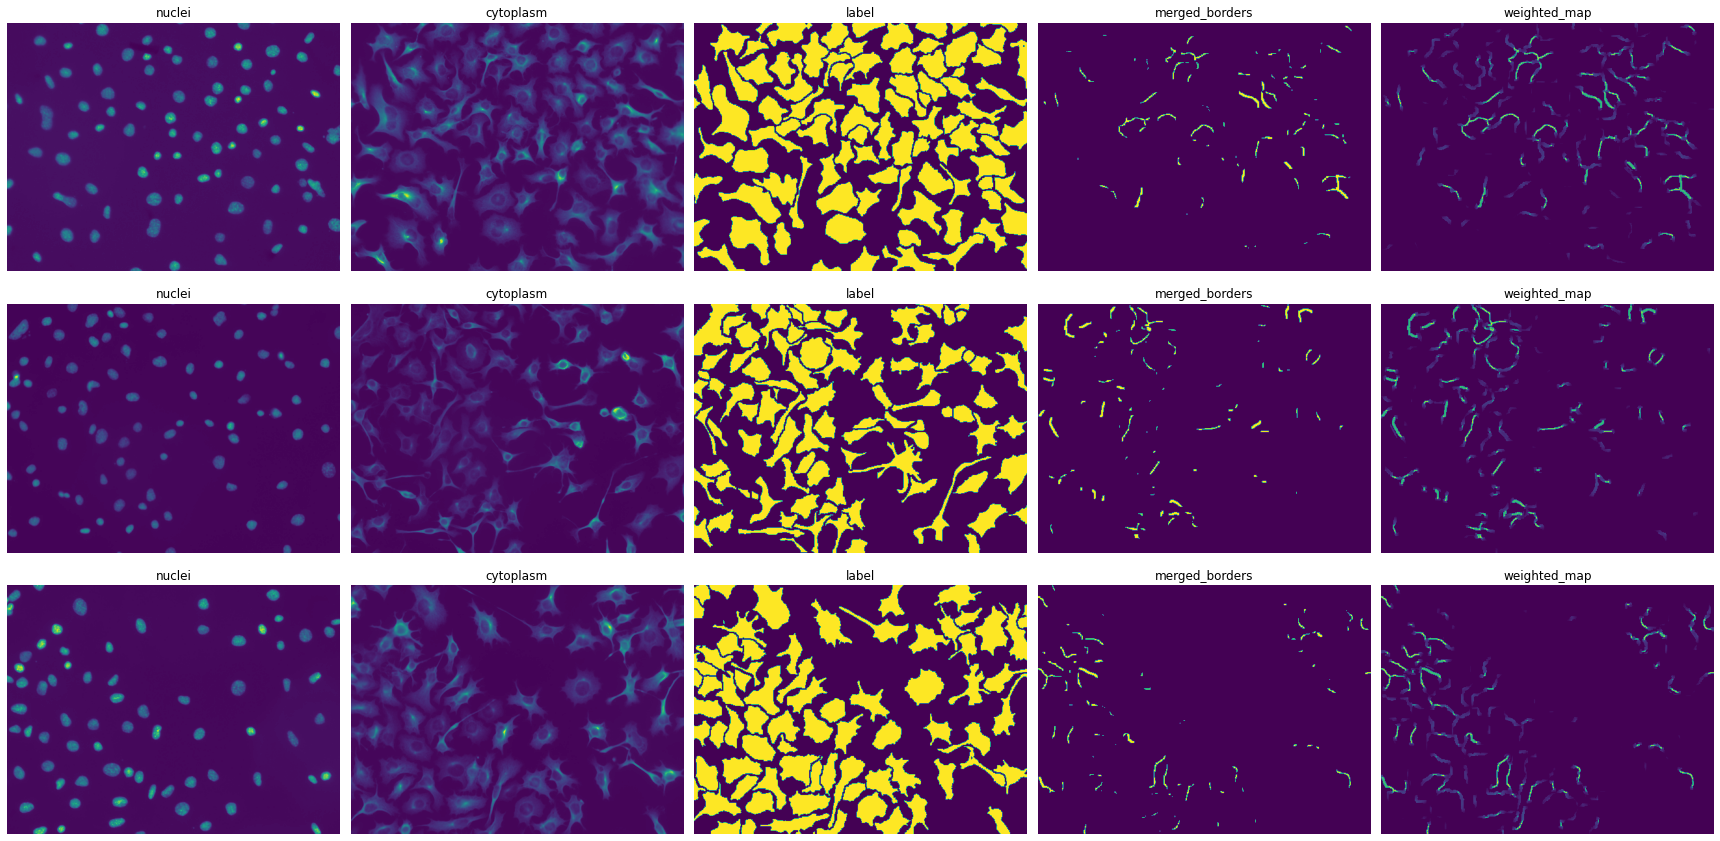

In [ ]:
plt.figure(figsize=(24, 12))
for j in range(3):
  plt.subplot(3, 5, 5*j + 1)
  plt.imshow(imgs_train[j][1])
  plt.title('nuclei')
  plt.axis('off')

  plt.subplot(3, 5, 5*j + 2)
  plt.imshow(imgs_train[j][0])
  plt.title('cytoplasm')
  plt.axis('off')

  plt.subplot(3, 5, 5*j + 3)
  plt.imshow(cell_labels_train[j])
  plt.title('label')
  plt.axis('off')

  plt.subplot(3, 5, 5*j + 4)
  plt.imshow(merged_borders_train[j])
  plt.title('merged_borders')
  plt.axis('off')

  plt.subplot(3, 5, 5*j + 5)
  plt.imshow(weighted_map_train[j])
  plt.title('weighted_map')
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
w_labels_train = np.stack((weighted_map_train, cell_labels_train), axis=1)
w_labels_test = np.stack((weighted_map_test, cell_labels_test), axis=1)
w_labels_train.shape , w_labels_test.shape 

((81, 2, 383, 512), (10, 2, 383, 512))

## Create transform function for augmentations

adapted from [cellpose/transforms.py](https://github.com/MouseLand/cellpose/blob/master/cellpose/transforms.py).

In [ ]:
def random_rotate_and_resize(X, Y=None, scale_range=0.5, xy=(224, 224),
                             do_flip=True, elastic=True):
  """
  Augmentation by random rotation, resizing, affine transform and elastic deformation

  X and Y are lists or arrays of length nimg, with dims channels x Ly x Lx (channels optional)

  Parameters
  ----------
  X: ND-array, float
    list of IMAGE arrays of size [nchan x Ly x Lx] or [Ly x Lx]

  Y: ND-array, float or int (optional, default None)
    list of MASK arrays of size [nlabels x Ly x Lx] or [Ly x Lx].
    ** These labels are nearest neighbor interpolated
    ** CHANGE IF USING FLOAT LABELS
  
  out_size = 

  scale_range: float (optional, default 1.0)
    Range of resizing of images for augmentation. Images are resized by
    (1-scale_range/2) + scale_range * np.random.rand()

  xy: tuple, int (optional, default (224,224))
    size of transformed images to return

  do_flip: bool (optional, default True)
    whether or not to flip images horizontally

  Returns
  -------
  imgi: ND-array, float
    transformed images in array [nimg x nchan x xy[0] x xy[1]]

  lbl: ND-array, float
    transformed labels in array [nimg x nchan x xy[0] x xy[1]]

  scale: array, float
    amount each image was resized by
  """

  scale_range = max(0, min(2, float(scale_range)))   #it needed be in 1 +/- 1 ==> (0,2) 
  nimg = len(X)
  if X[0].ndim > 2:
    nchan = X[0].shape[0]
  else:
    nchan = 1
  imgi  = np.zeros((nimg, nchan, xy[0], xy[1]), np.float32)

  lbl = []
  if Y is not None:
    if Y[0].ndim > 2:
      nt = Y[0].shape[0]
    else:
      nt = 1
    lbl = np.zeros((nimg, nt, xy[0], xy[1]), Y.dtype)

  scale = np.zeros(nimg, np.float32)
  
  for n in range(nimg):
    Ly, Lx = X[n].shape[-2:]   #find image size

    # generate random augmentation parameters
    flip = np.random.rand() > .5
    theta = np.random.rand() * np.pi * 2
    scale[n] = (1 - scale_range / 2) + scale_range * np.random.rand()    #range(1-scale_range/2 , 1+scale_range/2)
    dxy = np.maximum(0, np.array([Lx*scale[n] - xy[1], Ly * scale[n] - xy[0]]))
    dxy = (np.random.rand(2,) - .5) * dxy

    # create affine transform
    cc = np.array([Lx / 2, Ly / 2])
    cc1 = cc - np.array([Lx - xy[1], Ly - xy[0]]) / 2 + dxy
    pts1 = np.float32([cc, cc + np.array([1, 0]), cc + np.array([0, 1])])
    pts2 = np.float32([cc1,
            cc1 + scale[n]*np.array([np.cos(theta), np.sin(theta)]),
            cc1 + scale[n]*np.array([np.cos(np.pi/2 + theta),
                                     np.sin(np.pi/2 + theta)])])

    M = cv2.getAffineTransform(pts1, pts2)

    img = X[n].copy()
    if Y is not None:
      labels = Y[n].copy()
      if labels.ndim < 3:
        labels = labels[np.newaxis, :, :]

    if flip and do_flip:
      img = img[..., ::-1]
      if Y is not None:
        labels = labels[..., ::-1]

    if elastic:
      if Y is not None:
        img[0], img[1], labels[0], labels[1] = elasticdeform.deform_random_grid([img[0], img[1], labels[0], labels[1]], sigma=25, points=3, mode='constant', prefilter=False)
        img = np.concatenate((np.expand_dims(img[0], axis=0), np.expand_dims(img[1], axis=0)), axis=0)
        labels[0], labels[1] = np.expand_dims(labels[0], axis=0), np.expand_dims(labels[1], axis=0)
        labels = np.concatenate((np.expand_dims(labels[0], axis=0), np.expand_dims(labels[1], axis=0)), axis=0)

      else : 
        img[0], img[1] = elasticdeform.deform_random_grid([img[0], img[1]], sigma=25, points=3, mode='constant', prefilter=False)
        img = np.concatenate((np.expand_dims(img[0], axis=0), np.expand_dims(img[1], axis=0)), axis=0)

    for k in range(nchan):
      I = cv2.warpAffine(img[k], M, (xy[1], xy[0]), flags=cv2.INTER_LINEAR)
      imgi[n,k] = I

    if Y is not None:
      for k in range(nt):
        # ** nearest neighbor interpolation **
        # may need to change for float labels
        lbl[n,k] = cv2.warpAffine(labels[k], M, (xy[1], xy[0]),
                                  flags=cv2.INTER_NEAREST)

  return imgi, lbl, scale


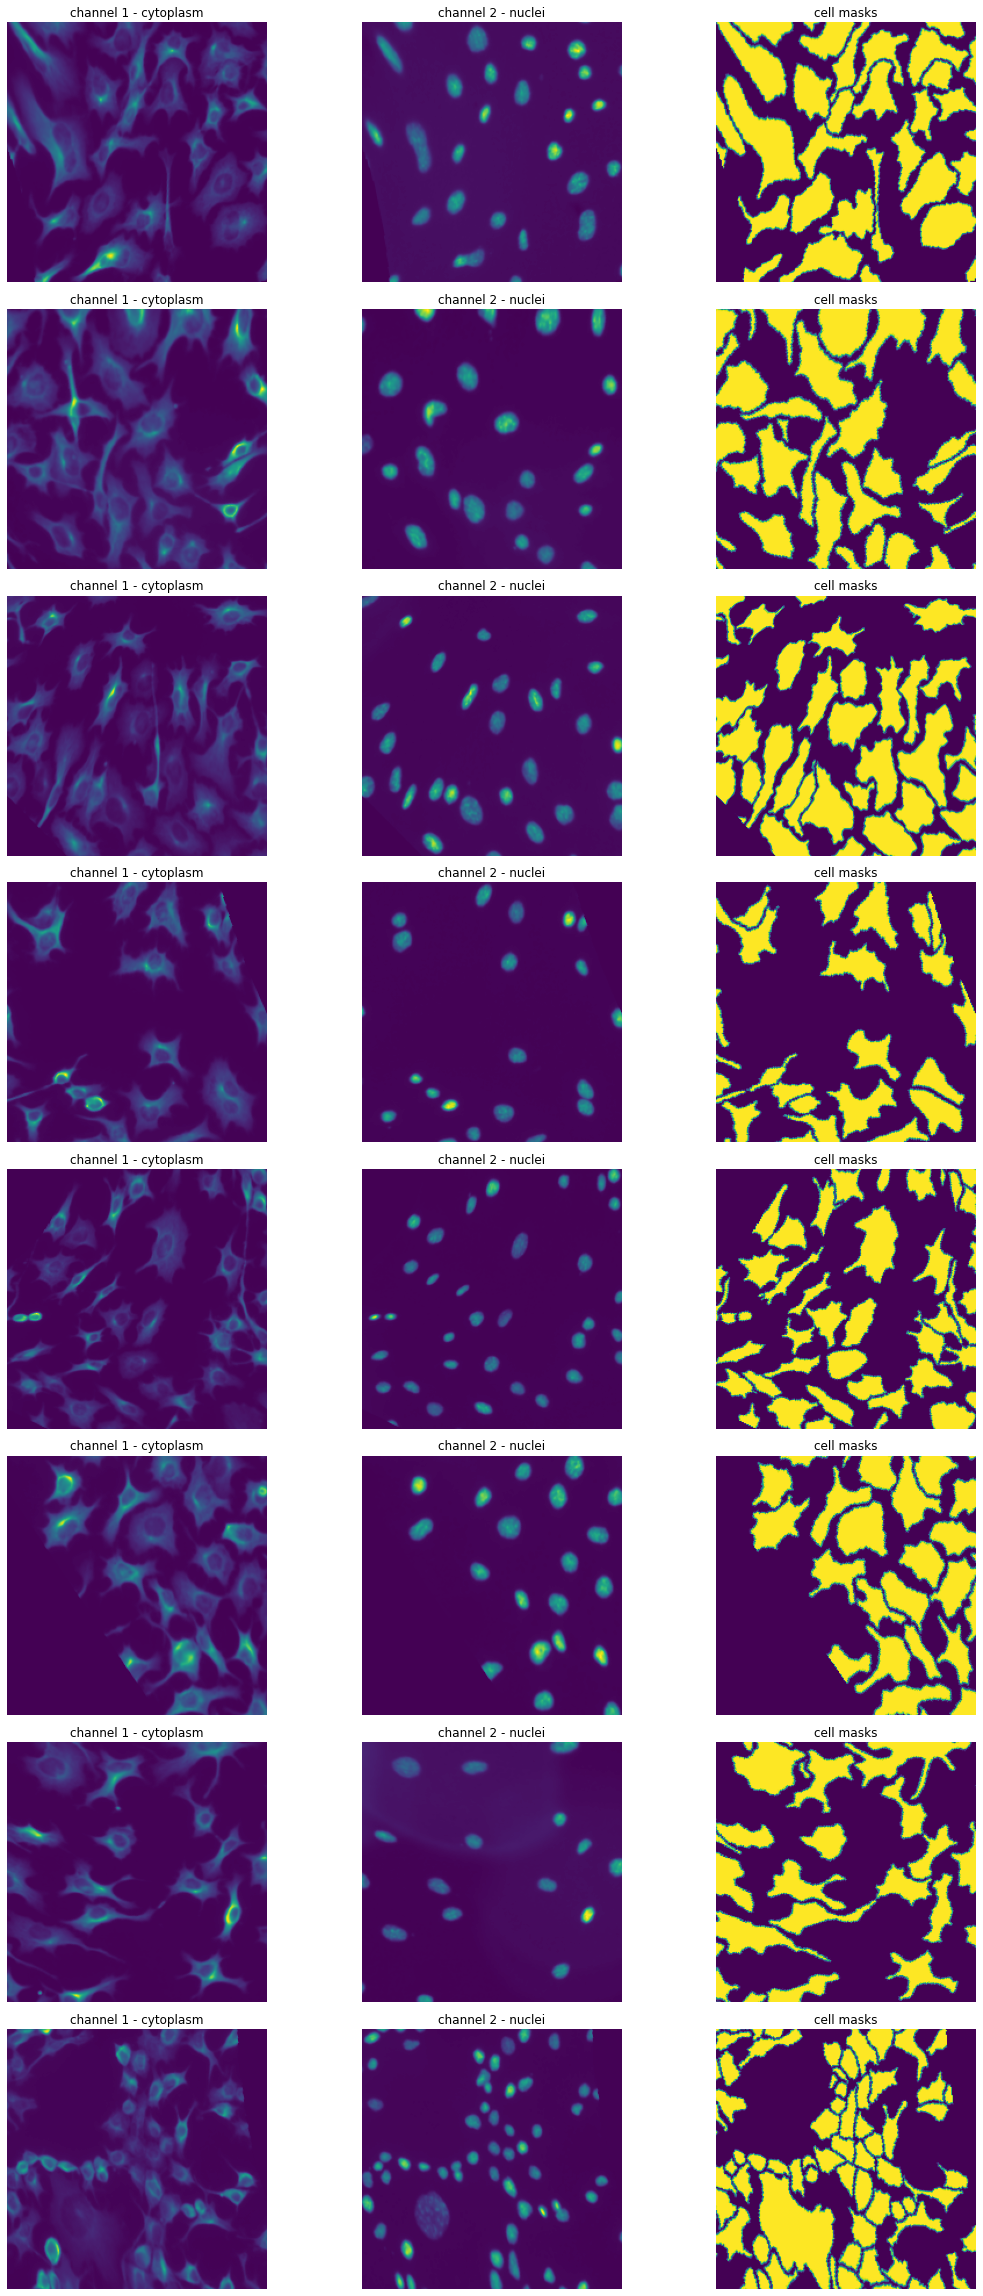

In [ ]:
img_batch, lbl_batch, scale = random_rotate_and_resize(imgs_train[:8],
                                                       w_labels_train[:8])

plt.figure(figsize=(16, 32))
for j in range(8):
  plt.subplot(8, 3, 3*j + 1)
  plt.imshow(img_batch[j, 0])
  plt.title('channel 1 - cytoplasm')
  plt.axis('off')

  plt.subplot(8, 3, 3*j + 2)
  plt.imshow(img_batch[j, 1])
  plt.title('channel 2 - nuclei')
  plt.axis('off')

  plt.subplot(8, 3, 3*j + 3)
  plt.imshow(lbl_batch[j, 1])
  plt.title('cell masks')
  plt.axis('off')
plt.tight_layout()
plt.show()

# Model architecture (u-net)



In [ ]:
def convbatchrelu(in_channels, out_channels, sz, threshold):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, sz, padding=sz//2),
      nn.BatchNorm2d(out_channels, eps=1e-5),
      nn.ReLU(inplace=True),
      nn.Dropout(threshold)
      )


class convdown(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, threshold):
    super().__init__()
    self.conv = nn.Sequential()
    for t in range(2):
      if t == 0:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(in_channels,
                                           out_channels,
                                           kernel_size,
                                           threshold))
      else:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(out_channels,
                                           out_channels,
                                           kernel_size,
                                           threshold))

  def forward(self, x):
    x = self.conv[0](x)
    x = self.conv[1](x)
    return x


class downsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.down = nn.Sequential()
    self.maxpool = nn.MaxPool2d(2, 2)
    p = np.linspace(0, 0.8, len(nbase)-1) # here we define the probability(p) of the dropout for each downsampling block
    for n in range(len(nbase) - 1):
      if n != len(nbase) - 2:
          self.down.add_module('conv_down_%d'%n,
                           convdown(nbase[n],
                                    nbase[n + 1],
                                    kernel_size,
                                    p[n]))          # dropouts probability(increase as we dig deeper into the network)
      else:
          self.down.add_module('conv_down_%d'%n,
                           convdown(nbase[n],
                                    nbase[n + 1],
                                    kernel_size,
                                    p[n]))

  def forward(self, x):
    xd = []
    for n in range(len(self.down)):
      if n > 0:
        y = self.maxpool(xd[n - 1])
        # xd.append(self.down[n-1](y))
      else:
        y = x
      xd.append(self.down[n](y))
    return xd


class convup(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.conv = nn.Sequential()
    self.conv.add_module('conv_0', convbatchrelu(in_channels + out_channels,
                                                 out_channels,
                                                 kernel_size,
                                                 0))
    self.conv.add_module('conv_1', convbatchrelu(out_channels,
                                                 out_channels,
                                                 kernel_size,
                                                 0))

  def forward(self, x, y):
    x = self.conv[0](torch.cat((x,y),1))
    x = self.conv[1](x)
    return x


class upsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')
    self.up = nn.Sequential()
    for n in range(len(nbase) - 1 , 0, -1):
      self.up.add_module('conv_up_%d'%(n - 1),
              convup(nbase[n], nbase[n - 1], kernel_size))

  def forward(self, xd):
    x = xd[-1]
    for n in range(0, len(self.up)):
      # if n > 0:
      x = self.upsampling(x)
      x = self.up[n](x, xd[len(xd) - 2 - n])
    return x


class Unet(nn.Module):
  def __init__(self, nbase, nout, kernel_size):
    super(Unet, self).__init__()
    self.nbase = nbase
    self.nout = nout
    self.kernel_size = kernel_size
    self.downsample = downsample(nbase, kernel_size)
    nbaseup = nbase[1:]
    # nbaseup.append(nbase[-1])
    self.upsample = upsample(nbaseup, kernel_size)
    self.output = nn.Conv2d(nbase[1], self.nout, kernel_size,
                            padding=kernel_size//2)

  def forward(self, data):
    T0 = self.downsample(data)
    T0 = self.upsample(T0)
    T0 = self.output(T0)
    return T0


  def save_model(self, filename):
    torch.save(self.state_dict(), filename)

  def load_model(self, filename, cpu=False):
    if not cpu:
      self.load_state_dict(torch.load(filename))
    else:
      self.__init__(self.nbase,
                    self.nout,
                    self.kernel_size,
                    self.concatenation)

      self.load_state_dict(torch.load(filename,
                                      map_location=torch.device('cpu')))

### Define the network

In [ ]:
kernel_size = 3
nbase = [2, 32, 64, 128, 256, 512, 1024]  # number of channels per layer
nout = 2  # number of outputs

net = Unet(nbase, nout, kernel_size)
# put on GPU here if you have it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device);  # remove semi-colon to see net structure

### Train the network


<a list of 512 Lists of Patches objects>

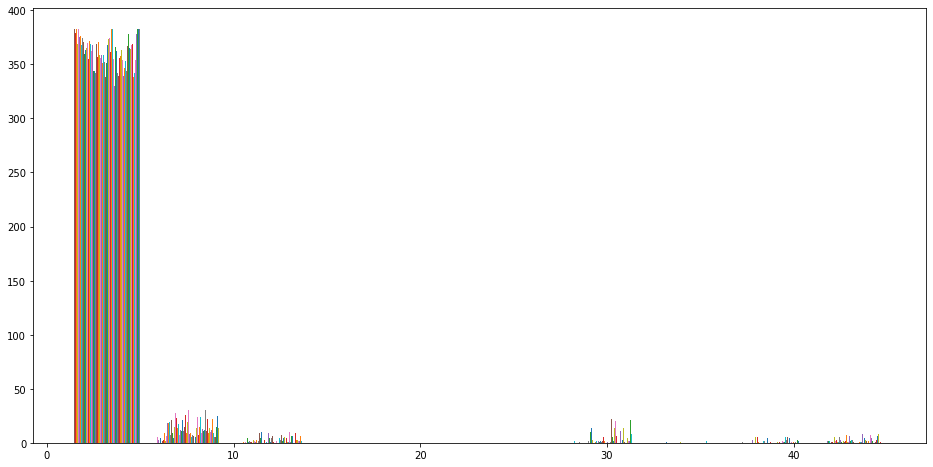

In [ ]:
w1_labels_train = np.ones_like(w_labels_train)
w1_labels_train[:,0] = (w_labels_train[:,0]*15)+1
plt.figure(figsize=(16,8))
plt.hist(w1_labels_train[0][0])[2]

In [ ]:
from numpy.core.numeric import ones_like
from datetime import datetime

# train the network
# parameters related to training the network
batch_size = 16 # number of images per batch -- amount of required memory
              # for training will increase linearly in batchsize
### you will want to increase n_epochs!
n_epochs = 3000 # number of times to cycle through all the data during training
learning_rate = 0.05 # initial learning rate
weight_decay = 1e-5 # L2 regularization of weights
momentum = 0.9 # how much to use previous gradient direction
n_epochs_per_save = 200 # how often to save the network
val_frac = 0.1 # what fraction of data to use for validation

# where to save the network
# make sure to clean these out every now and then, as you will run out of space
now = datetime.now()
timestamp = now.strftime('%Y%m%dT%H%M%S')

# split into train and validation datasets
n_val = int(len(imgs_train) * val_frac)
n_train = len(imgs_train) - n_val
np.random.seed(0)
iperm = np.random.permutation(len(imgs_train))   #shuffled indices
train_data, val_data = imgs_train[iperm[:n_train]], imgs_train[iperm[n_train:]]
train_labels, val_labels = w_labels_train[iperm[:n_train]], w_labels_train[iperm[n_train:]]
train_masks, val_masks = masks_train[iperm[:n_train]], masks_train[iperm[n_train:]]


# gradient descent flavor
optimizer = torch.optim.SGD(net.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay,
                            momentum=0.9)

# set learning rate schedule
LR = np.ones(n_epochs)*learning_rate
if n_epochs > 250 :
	  LR[:250] = learning_rate
	  for i in range((n_epochs//250 )- 1):
		    LR[(i+1)*250:(i+2)*250] = LR[(((i+1)*250)-1)]*0.75
	  LR[(n_epochs//250 )*250:] = LR[(((n_epochs//250 )*250)-1)]/2


# set weight map schedule
w_scale = 15
w_range = np.linspace(0, w_scale, 5)
w = np.ones(n_epochs)

for i in range(300):
  w[i] = w_range[1]
for i in range(300,1000):
  w[i] = w_range[2]
for i in range(1000,2000):
  w[i] = w_range[3]
for i in range(2000,3000):
  w[i] = w_range[4]


criterion = nn.CrossEntropyLoss(reduction='none')


# store loss per epoch
epoch_losses = np.zeros(n_epochs)
epoch_losses[:] = np.nan

val_losses = np.zeros(n_epochs)
val_losses[:] = np.nan

# when we last saved the network
saveepoch = None

In [ ]:
# loop through entire training data set nepochs times
for epoch in range(n_epochs):
   
  epoch_loss = 0
  epoch_loss_val = 0
  iters = 0
  for param_group in optimizer.param_groups:
    param_group['lr'] = LR[epoch]
  with tqdm.tqdm(total=n_train, desc=f"Epoch {epoch + 1}/{n_epochs}", unit='img', colour="#30D5C8", ) as pbar:
    # loop through each batch in the training data
    # put in train mode (affects batchnorm)
    net.train()
    for ibatch in np.arange(0, n_train, batch_size):
      # augment the data
      inds = np.arange(ibatch, min(n_train, ibatch+batch_size))
      imgs, lbls, _ = random_rotate_and_resize(train_data[inds], train_labels[inds], elastic = False)

      # transfer to torch + GPU
      imgs = torch.from_numpy(imgs).to(device=device)
      lbls = torch.from_numpy(lbls).to(device=device)

      # compute the loss
      y = net(imgs)

      loss = criterion(y, lbls[:, 1].to(dtype=torch.long))   #labels are float and needed to convert to long for Cross entropy

      loss = ((lbls[:, 0]*w[epoch])+1)*loss       #the weighted map values are between 0-1 so we multiply them to 10 to 
                                                  #increse the loss for wrong labels between close cells   
                                                  #+1 : to not zero out true cell labels

      loss = torch.sum(loss.flatten(start_dim=1), axis=0)
      loss = torch.mean(loss)

      epoch_loss += loss.item()
      epoch_loss = epoch_loss/len(imgs)
      pbar.set_postfix(**{'train_batch_loss': loss.item()})
      # gradient descent
      optimizer.zero_grad()
      loss.backward()
      #nn.utils.clip_grad_value_(net.parameters(), 0.1)
      optimizer.step()
      iters+=1
      pbar.update(imgs.shape[0])
    
    #compute validation loss
    net.eval()
    inds_val = np.arange(n_val)
    imgs_val, lbls_val,_ = random_rotate_and_resize(val_data[inds_val], val_labels[inds_val])     
    imgs_val = torch.from_numpy(imgs_val).to(device=device)    
    lbls_val = torch.from_numpy(lbls_val).to(device=device) 
    y = net(imgs_val)

    loss_val = criterion(y, lbls_val[:, 1].to(dtype=torch.long))
    loss_val = ((lbls_val[:, 0]*w[epoch])+1)*loss_val     
    loss_val = torch.sum(loss_val.flatten(start_dim=1), axis=0)
    loss_val = torch.mean(loss_val)

    epoch_loss_val += loss_val.item()
    epoch_loss_val = epoch_loss_val/len(imgs_val)

    epoch_losses[epoch] = epoch_loss
    val_losses[epoch] = epoch_loss_val
    pbar.set_postfix(**{'train_epoch_loss': epoch_loss , 'val_epoch_loss':epoch_loss_val})  #update('loss (epoch) = %f'%epoch_loss)
    
  # save checkpoint networks every now and then
  if epoch % n_epochs_per_save == 0:
    print(f"\nSaving network state at epoch {epoch+1}")
    saveepoch = epoch
    savefile = f"unet_epoch{saveepoch+1}.pth"
    net.save_model(savefile)
print(f"\nSaving network state at epoch {epoch+1}")
net.save_model(f"unet_epoch{epoch+1}.pth")

Epoch 1/3000: 100%|██████████| 73/73 [00:02<00:00, 25.80img/s, train_epoch_loss=1.71, val_epoch_loss=1.61e+4]



Saving network state at epoch 1


Epoch 201/3000: 100%|██████████| 73/73 [00:02<00:00, 25.41img/s, train_epoch_loss=0.184, val_epoch_loss=0.409]



Saving network state at epoch 201


Epoch 401/3000: 100%|██████████| 73/73 [00:02<00:00, 25.57img/s, train_epoch_loss=0.24, val_epoch_loss=0.463]



Saving network state at epoch 401


Epoch 601/3000: 100%|██████████| 73/73 [00:02<00:00, 25.74img/s, train_epoch_loss=0.201, val_epoch_loss=0.443]



Saving network state at epoch 601


Epoch 801/3000: 100%|██████████| 73/73 [00:02<00:00, 25.21img/s, train_epoch_loss=0.236, val_epoch_loss=0.41]



Saving network state at epoch 801


Epoch 1001/3000: 100%|██████████| 73/73 [00:02<00:00, 25.48img/s, train_epoch_loss=0.193, val_epoch_loss=0.494]



Saving network state at epoch 1001


Epoch 1201/3000: 100%|██████████| 73/73 [00:02<00:00, 25.48img/s, train_epoch_loss=0.227, val_epoch_loss=0.421]



Saving network state at epoch 1201


Epoch 1401/3000: 100%|██████████| 73/73 [00:02<00:00, 25.27img/s, train_epoch_loss=0.218, val_epoch_loss=0.455]



Saving network state at epoch 1401


Epoch 1601/3000: 100%|██████████| 73/73 [00:02<00:00, 25.25img/s, train_epoch_loss=0.176, val_epoch_loss=0.405]



Saving network state at epoch 1601


Epoch 1801/3000: 100%|██████████| 73/73 [00:02<00:00, 25.61img/s, train_epoch_loss=0.199, val_epoch_loss=0.491]



Saving network state at epoch 1801


Epoch 2001/3000: 100%|██████████| 73/73 [00:02<00:00, 25.67img/s, train_epoch_loss=0.295, val_epoch_loss=0.401]



Saving network state at epoch 2001


Epoch 2201/3000: 100%|██████████| 73/73 [00:02<00:00, 25.21img/s, train_epoch_loss=0.193, val_epoch_loss=0.58]



Saving network state at epoch 2201


Epoch 2401/3000: 100%|██████████| 73/73 [00:02<00:00, 25.54img/s, train_epoch_loss=0.207, val_epoch_loss=0.53]



Saving network state at epoch 2401


Epoch 2601/3000: 100%|██████████| 73/73 [00:02<00:00, 25.39img/s, train_epoch_loss=0.209, val_epoch_loss=0.475]



Saving network state at epoch 2601


Epoch 2801/3000: 100%|██████████| 73/73 [00:02<00:00, 25.54img/s, train_epoch_loss=0.187, val_epoch_loss=0.456]



Saving network state at epoch 2801


Epoch 3000/3000: 100%|██████████| 73/73 [00:02<00:00, 25.57img/s, train_epoch_loss=0.165, val_epoch_loss=0.617]



Saving network state at epoch 3000


<function matplotlib.pyplot.show>

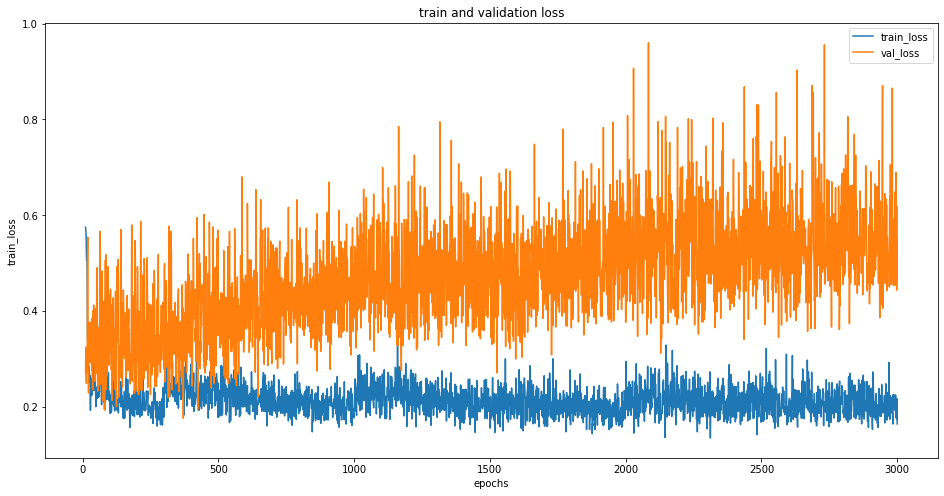

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(range(11,n_epochs+1), epoch_losses[10:], label='train_loss')
plt.plot(range(11,n_epochs+1), val_losses[10:], label='val_loss')
plt.title('train and validation loss')
plt.xlabel('epochs')
plt.ylabel('train_loss')
plt.legend(loc='upper right')
plt.show

In [ ]:
# To save weights, use this cell
torch.save( net, '/content/drive/MyDrive/u_s_weight_15_45_nbase1024__s_dropout.pth')
torch.save( net.state_dict(), '/content/drive/MyDrive/u_s_weight_15_45_nbase1024__3000epoch__s_dropout.pth')



In [ ]:
# # ## To load weights, use this cell
# net = torch.load('/content/drive/MyDrive/u_s_weight_15_45_nbase1024__s_dropout.pth')

# net.load_state_dict(torch.load('/content/drive/MyDrive/u_s_weight_15_45_nbase1024__2000epoch__s_dropout.pth'))
# net.eval()


### Test performance



In [ ]:
# @markdown Padding code for test images

def pad_image_ND(img0, div=16, extra=1):
  """ pad image for test-time so that its dimensions are a multiple of 16 (2D or 3D)

  Parameters
  -------------
  img0: ND-array
      image of size [nchan (x Lz) x Ly x Lx]
  div: int (optional, default 16)

  Returns
  --------------
  I: ND-array
      padded image
  slices: tuple, int
      range of pixels in I corresponding to img0
  """
  Lpad = int(div * np.ceil(img0.shape[-2] / div) - img0.shape[-2])
  xpad1 = extra * div//2 + Lpad//2
  xpad2 = extra * div//2 + Lpad - Lpad//2
  Lpad = int(div * np.ceil(img0.shape[-1] / div) - img0.shape[-1])
  ypad1 = extra * div//2 + Lpad//2
  ypad2 = extra * div//2 + Lpad - Lpad//2

  if img0.ndim > 3:
    pads = np.array([[0, 0], [0, 0], [xpad1, xpad2], [ypad1, ypad2]])
  else:
    pads = np.array([[0, 0], [xpad1, xpad2], [ypad1, ypad2]])

  I = np.pad(img0, pads, mode='constant')

  Ly, Lx = img0.shape[-2:]
  ysub = np.arange(xpad1, xpad1 + Ly)
  xsub = np.arange(ypad1, ypad1 + Lx)
  slc = [slice(0, img0.shape[n] + 1) for n in range(img0.ndim)]
  slc[-3] = slice(0, img0.shape[-3] + 1)
  slc[-2] = slice(ysub[0], ysub[-1] + 1)
  slc[-1] = slice(xsub[0], xsub[-1] + 1)
  slc = tuple(slc)

  return I, slc

In [ ]:
net.eval()
index = 6
test_padded, slices = pad_image_ND(imgs_test[index:index+1], 32)
test_torch = torch.from_numpy(test_padded).cuda()
out = net(test_torch)


<a list of 544 Lists of Patches objects>

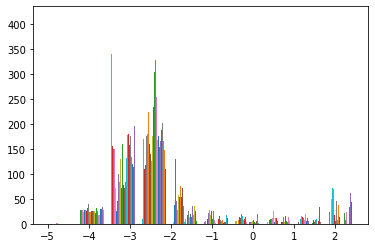

In [ ]:
plt.hist(np.array((out[0,1]).cpu().detach()))[2]

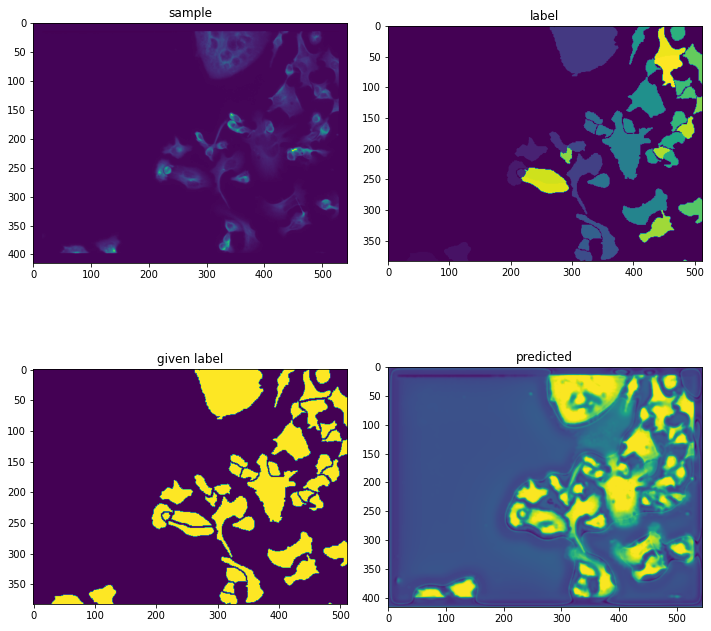

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.imshow(np.array(test_torch[0,0].cpu().detach()))
plt.title('sample')

plt.subplot(2, 2, 2)
plt.imshow(masks_test[index])
plt.title('label')

plt.subplot(2, 2, 3)
plt.imshow(w_labels_test[index,1])
plt.title('given label')

plt.subplot(2, 2, 4)
plt.imshow(np.array((out[0,1]-out[0,0]).cpu().detach()))
plt.title('predicted')
plt.tight_layout()
plt.show()

### Setting threshold for finding cells


In [ ]:
# @title Helper functions

# @markdown `fill_holes_and_remove_small_masks` function
def fill_holes_and_remove_small_masks(masks, min_size=15):
  """ fill holes in masks (2D/3D) and discard masks smaller than min_size (2D)

  fill holes in each mask using scipy.ndimage.morphology.binary_fill_holes

  Parameters
  ----------------
  masks: int, 2D or 3D array
      labelled masks, 0=NO masks; 1,2,...=mask labels,
      size [Ly x Lx] or [Lz x Ly x Lx]
  min_size: int (optional, default 15)
      minimum number of pixels per mask, can turn off with -1

  Returns
  ---------------
  masks: int, 2D or 3D array
      masks with holes filled and masks smaller than min_size removed,
      0=NO masks; 1,2,...=mask labels,
      size [Ly x Lx] or [Lz x Ly x Lx]
  """
  slices = find_objects(masks)
  j = 0
  for i,slc in enumerate(slices):
    if slc is not None:
      msk = masks[slc] == (i + 1)
      npix = msk.sum()
      if min_size > 0 and npix < min_size:
        masks[slc][msk] = 0
      else:
        if msk.ndim==3:
          for k in range(msk.shape[0]):
            msk[k] = binary_fill_holes(msk[k])
        else:
          msk = binary_fill_holes(msk)
        masks[slc][msk] = (j + 1)
        j += 1

  return masks


# @markdown `average_precision` function
def average_precision(masks_true, masks_pred, threshold=[0.5, 0.75, 0.9]):
  """ average precision estimation: AP = TP / (TP + FP + FN)

  This function is based heavily on the *fast* stardist matching functions
  (https://github.com/mpicbg-csbd/stardist/blob/master/stardist/matching.py)

  Parameters
  ------------
  masks_true: list of ND-arrays (int)
      where 0=NO masks; 1,2... are mask labels
  masks_pred: list of ND-arrays (int)
      ND-array (int) where 0=NO masks; 1,2... are mask labels

  Returns
  ------------
  ap: array [len(masks_true) x len(threshold)]
      average precision at thresholds
  tp: array [len(masks_true) x len(threshold)]
      number of true positives at thresholds
  fp: array [len(masks_true) x len(threshold)]
      number of false positives at thresholds
  fn: array [len(masks_true) x len(threshold)]
      number of false negatives at thresholds
  """
  if not isinstance(threshold, list) and not isinstance(threshold, np.ndarray):
    threshold = [threshold]
  ap  = np.zeros((len(masks_true), len(threshold)), np.float32)
  tp  = np.zeros((len(masks_true), len(threshold)), np.float32)
  fp  = np.zeros((len(masks_true), len(threshold)), np.float32)
  fn  = np.zeros((len(masks_true), len(threshold)), np.float32)
  n_true = np.array(list(map(np.max, masks_true)))
  n_pred = np.array(list(map(np.max, masks_pred)))
  for n in range(len(masks_true)):
    #_,mt = np.reshape(np.unique(masks_true[n], return_index=True), masks_pred[n].shape)
    if n_pred[n] > 0:
      iou = _intersection_over_union(masks_true[n], masks_pred[n])[1:, 1:]
      for k,th in enumerate(threshold):
        tp[n,k] = _true_positive(iou, th)
    fp[n] = n_pred[n] - tp[n]
    fn[n] = n_true[n] - tp[n]
    ap[n] = tp[n] / (tp[n] + fp[n] + fn[n])

  return ap, tp, fp, fn


@jit(nopython=True)
def _label_overlap(x, y):
  """ fast function to get pixel overlaps between masks in x and y

  Parameters
  ------------
  x: ND-array, int
      where 0=NO masks; 1,2... are mask labels
  y: ND-array, int
      where 0=NO masks; 1,2... are mask labels

  Returns
  ------------
  overlap: ND-array, int
      matrix of pixel overlaps of size [x.max()+1, y.max()+1]
  """
  x = x.ravel()
  y = y.ravel()
  overlap = np.zeros((1 + x.max(), 1 + y.max()), dtype=np.uint)
  for i in range(len(x)):
    overlap[x[i], y[i]] += 1

  return overlap


def _intersection_over_union(masks_true, masks_pred):
  """ intersection over union of all mask pairs

  Parameters
  ------------
  masks_true: ND-array, int
      ground truth masks, where 0=NO masks; 1,2... are mask labels
  masks_pred: ND-array, int
      predicted masks, where 0=NO masks; 1,2... are mask labels

  Returns
  ------------
  iou: ND-array, float
      matrix of IOU pairs of size [x.max()+1, y.max()+1]
  """
  overlap = _label_overlap(masks_true, masks_pred)
  n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
  n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
  iou = overlap / (n_pixels_pred + n_pixels_true - overlap)
  iou[np.isnan(iou)] = 0.0

  return iou


def _true_positive(iou, th):
  """ true positive at threshold th

  Parameters
  ------------
  iou: float, ND-array
      array of IOU pairs
  th: float
      threshold on IOU for positive label

  Returns
  ------------
  tp: float
      number of true positives at threshold
  """
  n_min = min(iou.shape[0], iou.shape[1])
  costs = -(iou >= th).astype(float) - iou / (2 * n_min)
  true_ind, pred_ind = linear_sum_assignment(costs)
  match_ok = iou[true_ind, pred_ind] >= th
  tp = match_ok.sum()

  return tp

In [ ]:
def get_masks_unet(output, cell_threshold=0, min_size=30):
  """ create masks using NOT CELL probability and CELL probability

  min_size: minimum number of pixels in the masks
  """

  cells = (output[1] - output[0]) > cell_threshold
  selem = generate_binary_structure(cells.ndim, connectivity=1)
  masks, nlabels = label(cells, selem)
  shape0 = masks.shape
  _,masks = np.unique(masks, return_inverse=True)
  masks = np.reshape(masks, shape0)
  # fill holes and remove small masks
  masks = fill_holes_and_remove_small_masks(masks, min_size=min_size)

  return masks.astype(np.uint16)


For our trained model, The maximum Precision occurs using cell_threshold = 0.20408163964748383
And the maximum precision is: 66.5247917175293%


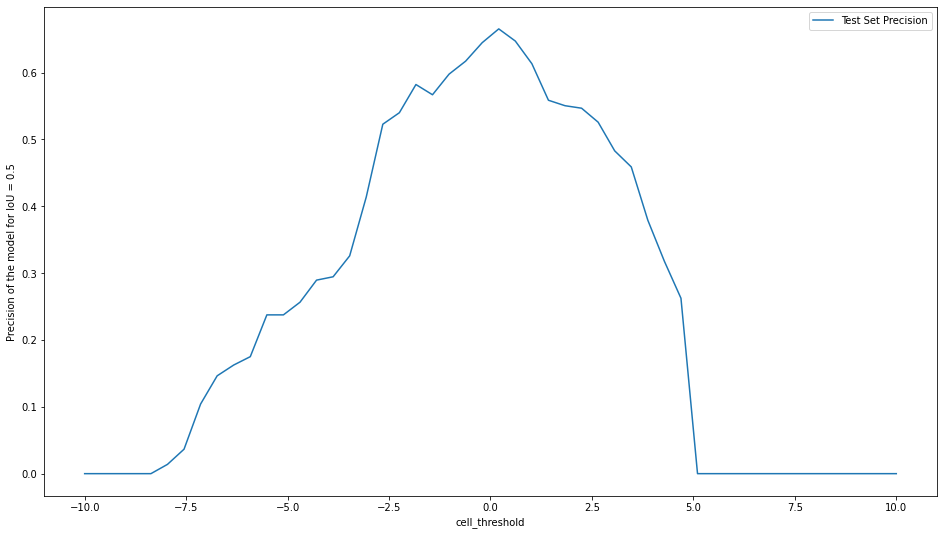

In [ ]:
# Used to calculate the precision of the model on the given dataset.
######### This function uses cell_threshold 
def calc_precision(imgs_test, masks_test):
    IoU_threshold = 0.5
    net.eval()
    ap_tot=[]
    # (depending on GPU capacity you may need to run this in a loop)
    for i in range ( 0, int(imgs_test.shape[0]), 2):

        test_padded, slices = pad_image_ND(imgs_test[i:i+2], 32)
        test_torch = torch.from_numpy(test_padded).to(device)
        out = net(test_torch)
    # compute CELL / NOT CELL probability
        labels = out[slices].detach().cpu().numpy()

    # create masks from probabilities
        masks = [get_masks_unet(lbl, cell_threshold=cell_threshold) for lbl in labels]

    # (note this function expects multiple masks)
        iou_threshold = np.array([IoU_threshold], "float64")
        ap = average_precision(masks_test[i:i+2], masks, threshold=iou_threshold)[0]
        ap_tot.append(ap)
        return np.array(ap_tot).mean()
    # precision_per_iter.append(np.array(ap_tot).mean(axis=1).mean(axis=0))
    net.train()
    
    
    
    
map_cell_threshold = np.linspace(-10, 10, num=50, endpoint=True, dtype="float32")
y_axis_ct = []
# tmp = cell_threshold
for index, i in enumerate(map_cell_threshold):
    cell_threshold = i
    y_axis_ct.append(calc_precision( val_data,val_masks))
    pass
# cell_threshold = tmp

figure, axes = plt.subplots()
plt.plot( map_cell_threshold, y_axis_ct, label="Test Set Precision");
plt.legend();
figure.set_size_inches(16, 9);
plt.xlabel("cell_threshold");
plt.ylabel("Precision of the model for IoU = 0.5")
max_index = np.argmax(y_axis_ct)
best_threshold = map_cell_threshold[np.argmax(y_axis_ct)]
print(f"""For our trained model, The maximum Precision occurs using cell_threshold = {best_threshold}
And the maximum precision is: {y_axis_ct[max_index] * 100}%""")

[0.67596334 0.59859514 0.48392695 0.35151556 0.15137431]


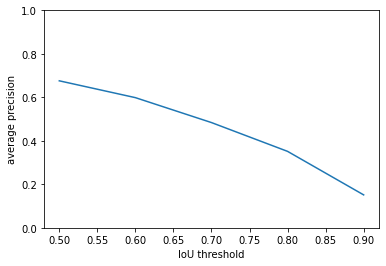

In [ ]:
net.eval()
ap_tot=[]
pred_masks = []
# (depending on GPU capacity you may need to run this in a loop)
for i in range ( 0, int(imgs_test.shape[0]), 2):
    
    test_padded, slices = pad_image_ND(imgs_test[i:i+2],32)
    test_torch = torch.from_numpy(test_padded).to(device)
    out = net(test_torch)
# compute CELL / NOT CELL probability
    labels = out[slices].detach().cpu().numpy()

# create masks from probabilities
    masks = [get_masks_unet(lbl, cell_threshold=best_threshold) for lbl in labels]
    pred_masks.append(masks[0])
    pred_masks.append(masks[1])
    # print(np.array(masks).shape)

# (note this function expects multiple masks)
    iou_threshold = np.arange(0.5, 1, 0.1)
    ap = average_precision(masks_test[i:i+2], masks, threshold=iou_threshold)[0]
    ap_tot.append(ap)

pred_masks = np.array(pred_masks)
# plot results
print(np.array(ap_tot).mean(axis=1).mean(axis=0)) # why is it differrent?
plt.plot(iou_threshold, np.array(ap_tot).mean(0).mean(0))
plt.xlabel('IoU threshold')
plt.ylabel('average precision')
plt.ylim([0, 1])
plt.show()


In [ ]:
net.eval()
pred_num = []
true_num = []
# (depending on GPU capacity you may need to run this in a loop)
for i in range ( 0, int(imgs_test.shape[0]), 2):
    
    test_padded, slices = pad_image_ND(imgs_test[i:i+2], 32)
    test_torch = torch.from_numpy(test_padded).to(device)
    out = net(test_torch)
# compute CELL / NOT CELL probability
    labels = out[slices].detach().cpu().numpy()

# create masks from probabilities
    masks = [get_masks_unet(lbl, cell_threshold=best_threshold) for lbl in labels]
# Saving the number of cells
    true_num.append(np.max(masks_test[i]))
    true_num.append(np.max(masks_test[i+1]))
    
    pred_num.append(np.max(masks[0]))
    pred_num.append(np.max(masks[1]))

a = np.array(pred_num, dtype="int16")
b = np.array(true_num, dtype="int16")

np.mean(abs(a - b) / b)


0.08327450652868269

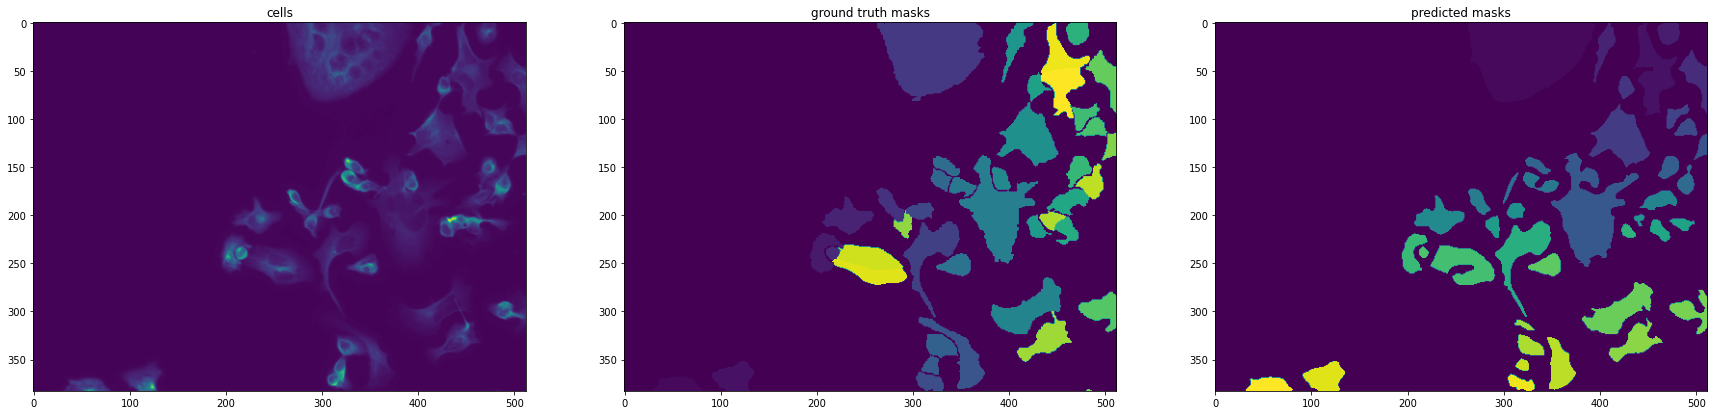

In [ ]:
idx = 6
plt.figure(figsize=(30, 15))
plt.subplot(1, 3, 1)
plt.imshow(imgs_test[idx,0])
plt.title('cells')
plt.subplot(1, 3, 2)
plt.imshow(masks_test[idx])
plt.title('ground truth masks')
plt.subplot(1, 3, 3)
plt.imshow(pred_masks[idx])
plt.title('predicted masks')
plt.show()